# Using Earth Access to Build and image

The goal is to use Earth Access to 

- load the rasters that cover Madison
- process them
- merge (or mosaic) them into one image

This is a reworking of 
[92-bulk-download](https://github.com/earthlab-education/fundamentals-04-redlining-byandell/blob/main/notebooks/redlining-92-bulk-download.ipynb).

In [1]:
city = "Madison"

In [2]:
import os # Interoperable file paths
import pathlib # Find the home folder

import geopandas as gpd # Work with vector data
import hvplot.pandas # Interactive plots of vector data
# conda install dask

In [3]:
import re # Use regular expressions to extract metadata

import earthaccess # Access NASA data from the cloud
import pandas as pd # Group and aggregate
import matplotlib.pyplot as plt # Overlay raster and vector data
import numpy as np # Process bit-wise cloud mask
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

In [4]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.1-py3-none-any.whl size=17467 sha256=d367c7f88a47e74838e2aae934a96493f8dfb33a7150bd86c59e48b0d974517d
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-htswow6y/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.1
    Uninstalling landmapy-0.1:
      Successfully uninstalled landmapy-0.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
import landmapy
from landmapy.redline import redline_gdf, plot_redline

In [6]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'redlining'
)
os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/brianyandell/earth-analytics/data/redlining'

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/brianyandell/earth-analytics/data/redlining/redlining/redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


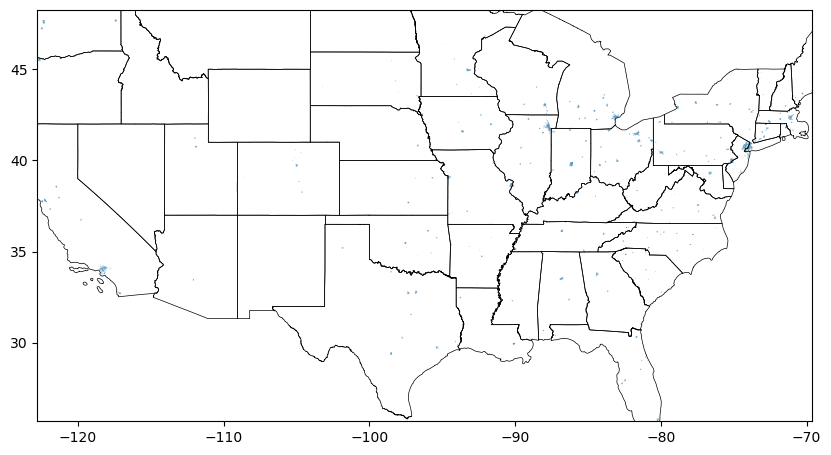

In [7]:
redlining_gdf = redline_gdf(data_dir)
plot_redline(redlining_gdf)

<Axes: >

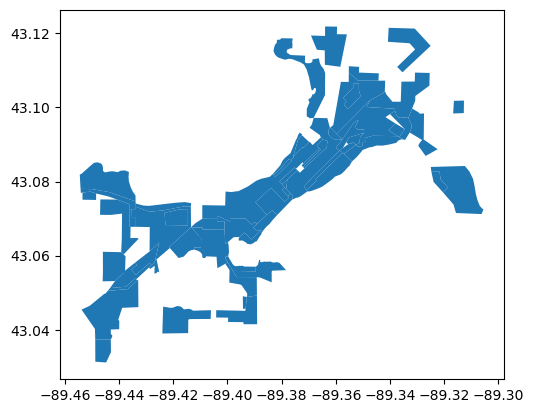

In [8]:
city_redlining_gdf = redlining_gdf[redlining_gdf.city == city]
city_redlining_gdf.plot()

## Set up Earth Access

The goal is to use Earth Access to

1. load the asters that cover selected `city`,
2. process them, and 
3. merge (or mosaic) them into one image

- Make an account on the [earthdata](https://urs.earthdata.nasa.gov/) site.
- Log in to your earthaccess account

In [9]:
earthaccess.login(strategy="interactive", persist=True)

- Search for the `city` data
- Open the file connections

In [10]:
# Search earthaccess
city_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(city_redlining_gdf.total_bounds),
    temporal=("2023-07-12", "2023-07-13"),
    count=1
)
city_files = earthaccess.open(city_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

## Get metadata with regular expressions

Extract metadata from file names and put them into a DataFrame.
Later we can group rasters by their metadata values, such as `tile ID`, `band ID`, and/or `date`.

- Access `file_name` with a string version of the URI using `.full_name` attribute.
- Build regular expression to parse `file_name`
    - See https://regex101.com/ with Python regular expression engine.
- Add the URIs from earthaccess to the DataFrame you created as a new column.

In [11]:
city_files[1].full_name

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B11.tif'

In [12]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"HLS\.L30\."
    r"(?P<tile_id>T[0-9A-Z]+)\."  # `tile_id`
    r"(?P<date>\d+)T\d+\.v2\.0\." # `date` as `yyyyjjj` (year and Julian date)
    r"(?P<band_id>.+)\.tif")      # `band_id`
uri_re

re.compile(r'HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif',
           re.UNICODE)

In [13]:
# Find all the metadata in the file name
uri_groups = [
    uri_re.search(city_file.full_name).groupdict()
    for city_file in city_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = city_files

# Check the results
raster_df.head()

,tile_id,date,band_id,file
0,T16TCN,2023194,SAA,"<File-like object HTTPFileSystem, https://data..."
1,T16TCN,2023194,B11,"<File-like object HTTPFileSystem, https://data..."
2,T16TCN,2023194,B01,"<File-like object HTTPFileSystem, https://data..."
3,T16TCN,2023194,VZA,"<File-like object HTTPFileSystem, https://data..."
4,T16TCN,2023194,B09,"<File-like object HTTPFileSystem, https://data..."


## Create Process Functions

Build **DRY** (Don’t Repeat Yourself) code. That is, write once, use often.
Functions here are

- process_image()
- process_cloud_mask()

In [14]:
city_files

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.SAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B11.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B01.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.VZA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B09.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

In [15]:
from landmapy.process import process_image, process_cloud_mask
help(process_image)

Help on function process_image in module landmapy.process:

process_image(uri, bounds_gdf)
    Load, crop, and scale a raster image from earthaccess
    
    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    
    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster



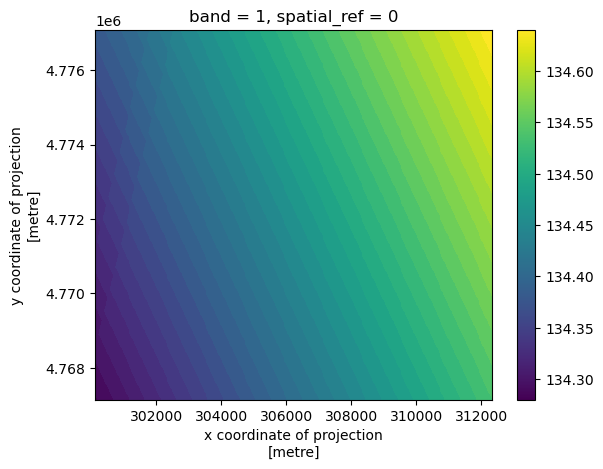

In [16]:
process_image(city_files[0], city_redlining_gdf).plot()

In [17]:
help(process_cloud_mask)

Help on function process_cloud_mask in module landmapy.process:

process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask)
    Load an 8-bit Fmask file and process to a boolean mask
    
    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set
    
    Returns
    -------
    cloud_mask: np.array
      Cloud mask



/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/landmapy/process.py:66: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


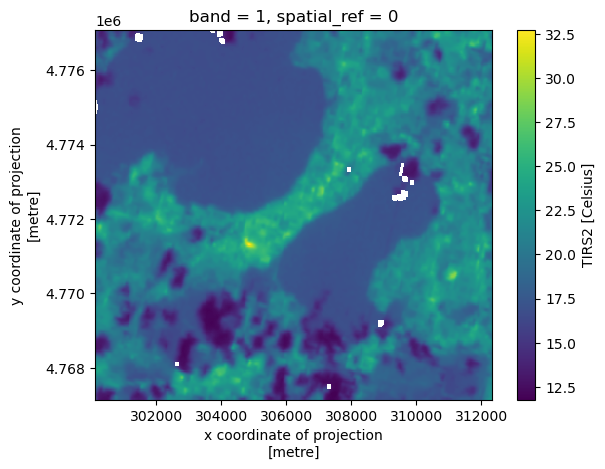

In [18]:
blue_da = process_image(city_files[1], city_redlining_gdf)
city_cloud_mask = process_cloud_mask(
    city_files[-1],
    city_redlining_gdf,
    [1, 2, 3, 5])
blue_da.where(city_cloud_mask).plot()

## Process Raster Files

Process all your bands using functions with appropriate arguments.
Caution that `DataFrames` tend to wrap values in external structures like `Series` (data type of columns in a `DataFrame`). To get a value out from inside a `Series`, use `.values[0]`, which removes the Series wrapper and the gets the first value in the array.

In [19]:
# Labels for each band to process
bands = {
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir'
}
# Initialize structure for saving images
city_das = {band_name: [] for band_name in bands.values()}
print('Loading...')
for tile_id, tile_df in raster_df.groupby('tile_id'):
    print(tile_id)
    # Load the cloud mask
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file, 
        city_redlining_gdf, 
        [1, 2, 3, 5])

    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            print(band_id, band_name)
            # Process band
            band_da = process_image(
                row.file.values[0], 
                city_redlining_gdf)

            # Mask band
            band_masked_da = band_da.where(cloud_mask)

            # Store the resulting DataArray for later
            city_das[band_name].append(band_masked_da)

print('Done.')

Loading...
T16TCN


/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/landmapy/process.py:66: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


B02 red
B03 green
B04 blue
B05 nir
Done.


### Merge Tiles

In [20]:
# Merge all tiles
city_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in city_das.items()}

In [21]:
%store city_merged_das

Stored 'city_merged_das' (dict)


In [22]:
city_merged_das.keys()

dict_keys(['red', 'green', 'blue', 'nir'])

Plot band merged across tiles.

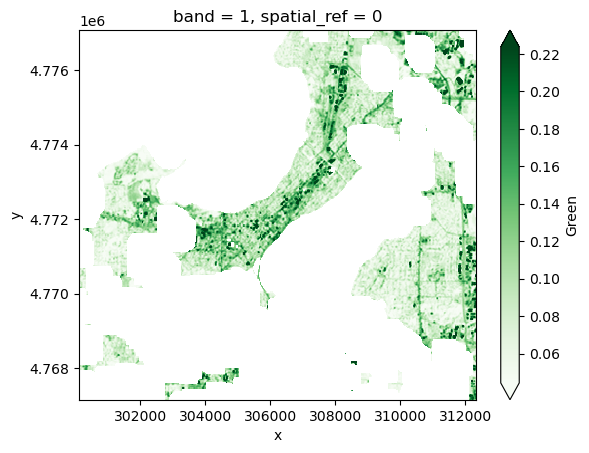

In [23]:
# Plot a merged raster band
city_merged_das['green'].plot(cmap='Greens', robust=True)

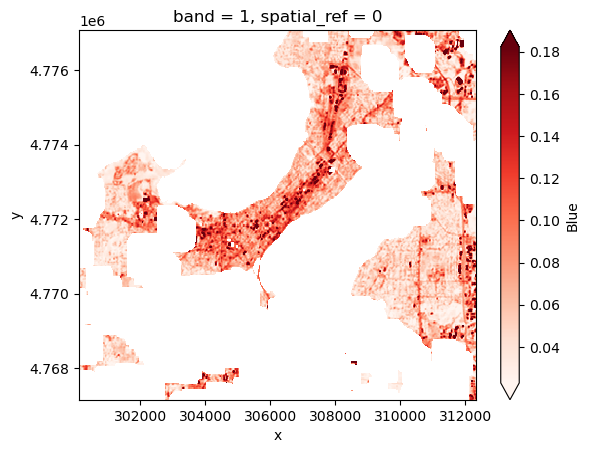

In [24]:
# Plot a merged raster band
city_merged_das['red'].plot(cmap='Reds', robust=True)

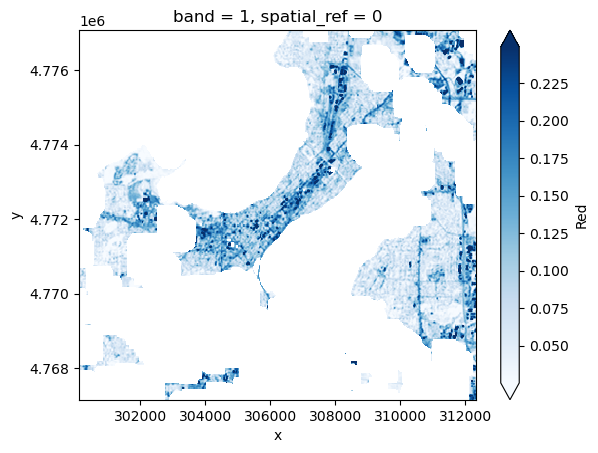

In [25]:
# Plot a merged raster band
city_merged_das['blue'].plot(cmap='Blues', robust=True)

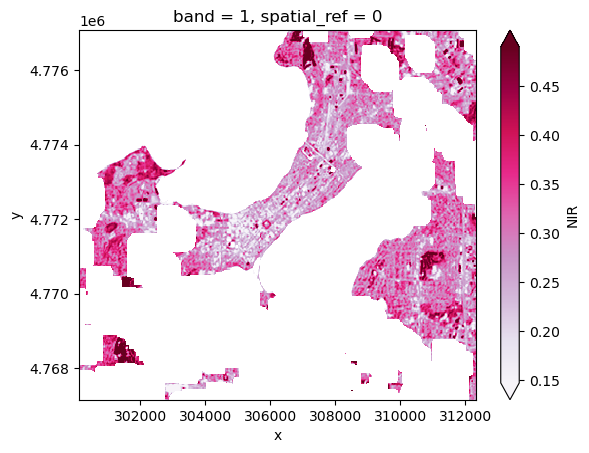

In [26]:
# Plot a merged raster band
city_merged_das['nir'].plot(cmap='PuRd', robust=True)

There is a list of `colormaps`. See
[Choosing Colormaps in Matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

In [27]:
city_merged_das['red']

<xarray.DataArray (y: 331, x: 407)> Size: 539kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.11319999, 0.0845    ,
        0.13759999],
       [       nan,        nan,        nan, ..., 0.1485    , 0.08859999,
        0.14209999],
       [       nan,        nan,        nan, ..., 0.1095    , 0.0825    ,
        0.094     ]], dtype=float32)
Coordinates:
  * x            (x) float64 3kB 3.001e+05 3.002e+05 ... 3.123e+05 3.123e+05
  * y            (y) float64 3kB 4.777e+06 4.777e+06 ... 4.767e+06 4.767e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            UNKNOWN; UNKNOWN
    TIRS_SSM_POSITION_STATUS:  UNKNOWN; UNKNOWN
    ULX:                       300000
    ULY:                       4800000
    USGS_SOFTWARE:             LPGS_16.3.0
    AREA_OR_POINT:             Area

In [ ]:
denver_ndvi_da = (
    (band_dict['nir'] - band_dict['red'])
    / (band_dict['nir'] + band_dict['red'])
)
denver_ndvi_da.plot(robust=True)

## Calculate Zonal Statistics

Summarize NDVI across the same geographic areas as
we have redlining information.

### Import packages

In [28]:
import os # Reproducible file paths
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob # Find files by pattern

import pandas as pd# Ordered categorical data
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt # Make subplots
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
import cartopy.crs as ccrs # CRSs
import hvplot.pandas # Interactive plots with pandas

In [ ]:
# Interactive plots with pandas
# Ordered categorical data
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics

### Convert vector to raster

Convert your vector data to a raster mask using the `regionmask` package
with the geographic coordinates of the grid for this to work.

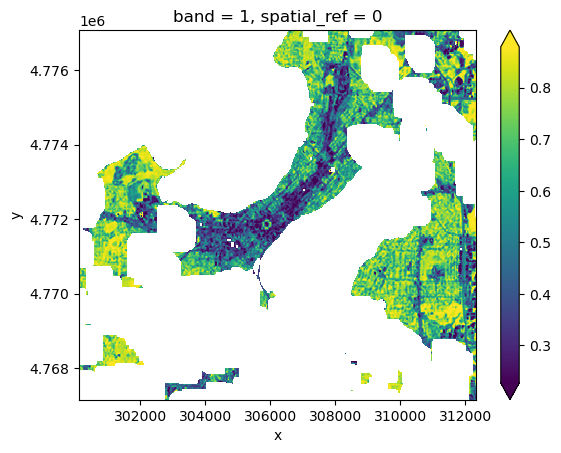

In [29]:
city_ndvi_da = (
    (city_merged_das['nir'] - city_merged_das['red'])
    / (city_merged_das['nir'] + city_merged_das['red'])
)
city_ndvi_da.plot(robust=True)

## Fitting Tree Model

Somehow I have to go from city_ndvi_da to redlining_ndvi_gdf.

In [34]:
import hvplot.pandas # Interactive plots with pandas
import matplotlib.pyplot as plt # Overlay raster and vector data
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

In [35]:
# Convert categories to numbers
redlining_ndvi_gdf['grade_codes'] = (
    redlining_ndvi_gdf.grade.cat.codes
)

# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    redlining_ndvi_gdf[['mean']],
    redlining_ndvi_gdf.grade_codes,
)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

NameError: name 'redlining_ndvi_gdf' is not defined

# Plotting multispectral data

Multispectral data can be plotted as:

1.  Individual bands
2.  Spectral indices
3.  True color 3-band images
4.  False color 3-band images

Spectral indices and false color images can both be used to enhance
images to clearly show things that might be hidden from a true color
image, such as vegetation health.

In [30]:
import cartopy.crs as ccrs # CRSs
# Interactive tabular and vector data
import hvplot.xarray # Interactive raster
# Overlay plots
import numpy as np # Adjust images
import xarray as xr # Adjust images
import matplotlib.pyplot as plt # Overlay plots
import hvplot.pandas# Interactive tabular and vector data

In [31]:
redlining_plot_gdf = city_redlining_gdf.to_crs(ccrs.Mercator())
ndvi_plot_da = city_ndvi_da.rio.reproject(ccrs.Mercator())
band_plot_dict = {
    name: da.rio.reproject(ccrs.Mercator())
    for name, da in band_dict.items()
}

ndvi_plot_da.plot(vmin=0, robust=True)
redlining_plot_gdf.plot(ax=plt.gca(), color='none')
plt.gca().set(
    xlabel='', ylabel='', xticks=[], yticks=[]
)
plt.show()

NameError: name 'band_dict' is not defined